In [29]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import eng_to_ipa as p
import math
import keras

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from scikeras.wrappers import KerasRegressor
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the data

In [12]:
df = pd.read_csv("/content/drive/MyDrive/ThesisPub/avgRatings_annotated.csv")
df.drop(df.columns[7:22], axis = 1, inplace = True)
df.head()

,name,age,polarity,name_type,rating.mean_age,rating.mean_gender,rating.mean_valence,gender
0,Adelaide,old,NaN,real,-0.617647,45.727273,NaN,female
1,Adelina,NaN,bad,real,NaN,47.771429,31.621622,female
2,Alasdair,young,NaN,real,18.709677,-35.657143,NaN,male
3,Alastor,old,NaN,madeup,13.812500,-38.833333,NaN,male
4,Alecto,old,NaN,madeup,3.593750,-35.722222,NaN,female


## Vectorize

### Letter Features

In [13]:
def count_vector(word):
    alphabet_string = string.ascii_lowercase
    alphabet_list = list(alphabet_string)
    
    vector = []
    for i in range(len(alphabet_list)):
        vector.append(word.lower().count(alphabet_list[i]))
        
    return vector

df["letter_vec"] = pd.NaT

vector_list = []
for i in range(len(df["name"])):
    cv = count_vector(df.loc[i]["name"])
    vector_list.append(cv)
    
varray = np.array(vector_list, dtype=int)

for i in range(len(df["name"])):
    df["letter_vec"].loc[i] = varray[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
feature_names_lf = list(string.ascii_lowercase)

### Phonological Features

In [15]:
ipa_temp = []

for name in df["name"].values:
    nipa = p.convert(name)
    if nipa[-1] == "*":
        ipa_temp.append("NA")
    else:
        ipa_temp.append(nipa)
  
print("NA value count: ", len([ipa_temp[i] for i in range(len(ipa_temp)) if ipa_temp[i] == "NA"]))
#print(ipa_temp)
df["IPA"] = ipa_temp

NA value count:  53


In [16]:
na_names_tr = pd.read_csv("/content/drive/MyDrive/ThesisPub/na_names.csv")

for i in range(len(df["name"])):
    for j in range(len(na_names_tr["name"])):
        if df["name"].loc[i] == na_names_tr["name"][j]:
            df["IPA"].loc[i] = na_names_tr["IPA"][j]

In [17]:
feature_dict = {"Obstruents": ["t","d","s","z","ɬ","ɮ","θ","ð","c","ɟ","ç","ʝ"],
                "Fricatives": ["ɸ","β","f","v","θ","ð","s","z","ʃ","ʒ","ʂ","ʐ","ç","ʝ","x","ɣ","χ","ʁ","ħ","ʕ","h","ɦ"],
                "Lateral Fricatives": ["ɬ","ɮ"],
                "Plosives": ["p","b","t","d","ʈ","ɖ","c","ɟ","k","g","q","ɢ","ʔ"],
                "Nasals": ["m","ɱ","n","ɳ","ɲ","ŋ","ɴ"],
                "Approximants": ["ʋ","ɹ","ɻ","j","ɰ"],
                "Lateral Approximants": ["l","ɭ","ʎ","ʟ"],
                "Alveolars": ["t","d","n","r","ɾ","s","z","ɬ","ɮ","ɹ","l"],
                "Glottals": ["ʔ","h","ɦ"],
                "Dentals": ["θ","ð"],
                "Bilabials": ["p","b","m","ʙ","ɸ","β"],
                "Sonorants": ["m","ɱ","n","ɳ","ɲ","ŋ","ɴ","l","ʎ","r","ɹ","ʀ"],
                "Velars": ["k","ɡ","ŋ","x","ɣ","ɰ","ʟ"],
                "Voiced": ["b","m","ʙ","β","ɱ","ⱱ","v","ʋ","ð","d","n","r","ɾ","z","ɮ","ɹ","l","ʒ","ɖ","ɳ","ɽ","ʐ","ɻ","ɭ","ɟ","ɲ","ʝ","j","ʎ","ɡ","ŋ","ɣ","ɰ","ʟ","ɢ","ɴ","ʀ","ʁ","ʕ","ɦ"],
                "Voiceless": ["p","ɸ","f","θ","t","s","ɬ","ʃ","ʈ","ʂ","c","ç","k","x","q","χ","ħ","ʔ","h"],
                "High": ["i","y","ɪ","ʏ","ɨ","ʉ","ʊ","ɯ","u"],
                "Mid": ["e","ø","ɘ","ɵ","ɤ","o","ə","ɛ","œ","ɜ","ɞ","ʌ","ɔ"],
                "Low": ["æ","ɐ","a","ɶ","ɑ","ɒ"],
                "Front": ["i","y","ɪ","ʏ","e","ø","ɛ","œ","æ","a","ɶ"],
                "Central": ["ɨ","ʉ","ɘ","ɵ","ə","ɜ","ɞ","ɐ"],
                "Back": ["ɯ","u","ʊ","ɤ","o","ʌ","ɔ","ɑ","ɒ"],
                "Rounded": ["y","ʏ","ø","œ","ɶ","ʉ","ɵ","ɞ","u","o","ɔ","ɒ"],
                "Unrounded": ["i","e","ɪ","ɛ","a","ɨ","ɘ","ɜ","ɯ","ɤ","ʌ","ɑ"]}

In [18]:
feature_names_pf = list(feature_dict.keys())

In [19]:
def get_phonological_features(word_ipa, feature_dict):
    word_pv = np.zeros((1, len(feature_dict.keys())), dtype=int)
    word_pvdf = pd.DataFrame(word_pv, columns=list(feature_dict.keys()))
    for i in range(len(word_ipa)):
        for key in list(feature_dict.keys()):
            if word_ipa[i] in feature_dict[key]:
                word_pvdf[key][0] += 1
    return word_pvdf.iloc[0]

df["phonological_vec"] = pd.NaT

vector_list = []
for i in range(len(df["IPA"])):
    phv = np.array(get_phonological_features(df.loc[i]["IPA"], feature_dict), dtype=int)
    vector_list.append(phv)
    
varray = np.array(vector_list, dtype=int)
varray

for i in range(len(df["name"])):
    df["phonological_vec"].loc[i] = varray[i]

# Training

In [32]:
def train_NN(input_df, feature_col, attribute_col):
    
    #cross-validation and model instantiations
    loo = LeaveOneOut()
    
    #-------- move this here for getting the input dimension
    
    #getting the data to be split
    xlist = [vector for vector in input_df[feature_col]]
    xarray = np.array(xlist, dtype=int)    

    X = xarray
    y = np.array(input_df[attribute_col],dtype=int)   
    
    #getting the names and their types of ease of use later on
    names = input_df["name"]
    types = input_df["name_type"]
    

    #list for the prediction of each name's rating
    predictions = []
    
    #--------
    
    def create_model(neurons,dropout_rate,activation):
        model = Sequential()
        model.add(Dense(neurons, input_dim = len(xarray[0]), kernel_initializer = 'normal', activation = activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation = 'linear'))
        
        callback = EarlyStopping(monitor = 'loss', patience=3, verbose=0) 
        
        model.compile(loss = 'mse', optimizer = "adam")
        return model
    
    #set random seed
    seed = 7
    tf.random.set_seed(seed)

    # Create the model
    model = KerasRegressor(model= create_model, verbose = 0, batch_size = 40, epochs = 10)

    # Define the grid search parameters
    lrelu = keras.layers.LeakyReLU()

    neurons = [8,16,len(xarray[0])]
    dropout_rate = [0.2,0.5]
    activation = [lrelu, 'tanh', 'sigmoid']

    # Make a dictionary of the grid search parameters

    param_grids = dict(model__neurons=neurons, model__dropout_rate=dropout_rate, model__activation=activation)

    # Build and fit the GridSearchCV

    grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 0)  

    #--------
    
    #do the cross validation split (test is going to be only one name and train is going to be every other name but that)
    for train_index, test_index in loo.split(X):
        x_train = X[train_index]
        x_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
    
        #list with names in the test set and their type, again for easier use later
        test_names = list(names.iloc[test_index])
        test_name_types = list(types.iloc[test_index])
    
        #fit the model on this fold's training set
        model = grid.fit(x_train,y_train)
        #predict the score for the test set (name)
        prediction = grid.predict(np.array(x_test))

        #append the name, its type, its feature representation, its actual rating, 
        #and its predicted rating and prediction probability into the predictions list
        for i in range(len(x_test)):
            predictions.append((test_names[i],test_name_types[i],x_test[i],y_test[i],prediction[i]))
            
        
    return predictions

In [21]:
def metrics_and_eval(predictions):
    #predictions: the prediction list we get from the training functions with the names, their name types, their feature representation
    #             their actual values, and their predicted values 
    
    r2 = r2_score([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    mae = mean_absolute_error([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    mse = mean_squared_error([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    med_ae = median_absolute_error([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    
    #-------------------------------------------------------------------------------------
    
    #split the absolute errors according to name type
    aes={"real":[], "talking":[], "madeup":[]}
    for i in range(len(predictions)):
        if predictions[i][1] == "real":
            aes["real"].append(abs(predictions[i][3] - predictions[i][4]))
        if predictions[i][1] == "talking":
            aes["talking"].append(abs(predictions[i][3] - predictions[i][4]))
        if predictions[i][1] == "madeup":
            aes["madeup"].append(abs(predictions[i][3] - predictions[i][4]))
            
    #take the average of the of the absolute error list for each name type
    avg_mae_per_nametype = {"real": np.mean(aes["real"]),
                            "talking": np.mean(aes["talking"]) ,
                            "madeup": np.mean(aes["madeup"])}
        
    
    return mae, avg_mae_per_nametype, r2, aes, mse, med_ae

## Polarity

In [22]:
pol_df = df.loc[df['polarity'].notnull(), ["name",  "name_type", "polarity", "rating.mean_valence", "letter_vec", "phonological_vec"]]
pol_df.reset_index(drop=True, inplace=True)

### - - - -

In [33]:
NNLF_pol = train_NN(pol_df, "letter_vec", "rating.mean_valence")

In [34]:
NNLFPOL_results = metrics_and_eval(NNLF_pol)

In [35]:
print("Avg MAE: ", NNLFPOL_results[0], "Avg MAE per name type: ", NNLFPOL_results[1], "R2: ", NNLFPOL_results[2], 
      "Avg MSE: ", NNLFPOL_results[4], "Median AE: ", NNLFPOL_results[5], sep="\n")

Avg MAE: 
19.323557276190037
Avg MAE per name type: 
{'real': 21.053871228173374, 'talking': 23.78417680254206, 'madeup': 13.940136860246243}
R2: 
-0.3111387528263576
Avg MSE: 
484.8663123131543
Median AE: 
21.40657326579094


In [36]:
NNPF_pol = train_NN(pol_df, "phonological_vec", "rating.mean_valence")

In [38]:
NNPFPOL_results = metrics_and_eval(NNPF_pol)

In [39]:
print("Avg MAE: ", NNPFPOL_results[0], "Avg MAE per name type: ", NNPFPOL_results[1], "R2: ", NNPFPOL_results[2], 
      "Avg MSE: ", NNPFPOL_results[4], "Median AE: ", NNPFPOL_results[5], sep="\n")

Avg MAE: 
19.000009906522575
Avg MAE per name type: 
{'real': 20.787940785940737, 'talking': 23.12682466991246, 'madeup': 13.856752825819928}
R2: 
-0.2605435490810901
Avg MSE: 
466.1559280705878
Median AE: 
20.81490957736969


In [40]:
NNLFPOL_pred = pd.DataFrame(NNLF_pol, columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
NNLFPOL_pred["Features"] = ["Letter" for i in range(len(NNLF_pol))]

NNPFPOL_pred = pd.DataFrame(NNPF_pol, columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
NNPFPOL_pred["Features"] = ["Phonological" for i in range(len(NNPF_pol))]

NNPOL_pred = NNLFPOL_pred.append(NNPFPOL_pred)

In [41]:
NNPOL_pred.to_csv("NNPOLpred.csv")

[Text(0.5, 1.0, 'Polarity')]

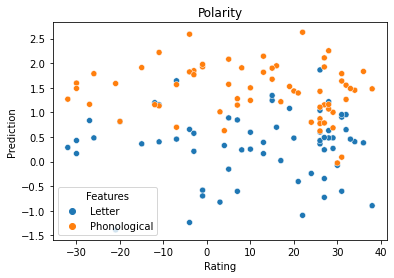

In [42]:
sns.scatterplot(x=NNPOL_pred["Rating"], y=NNPOL_pred["Prediction"], hue=NNPOL_pred["Features"]).set(title='Polarity')

### Gender

In [43]:
gen_df = df.loc[df['gender'].notnull(), ["name", "name_type","gender", "rating.mean_gender", "letter_vec", "phonological_vec"]]
gen_df.reset_index(drop=True, inplace=True)

### - - - -

In [44]:
NNLF_gen = train_NN(gen_df, "letter_vec", "rating.mean_gender")

In [45]:
NNLFGEN_results = metrics_and_eval(NNLF_gen)

In [46]:
print("Avg MAE: ", NNLFGEN_results[0], "Avg MAE per name type: ", NNLFGEN_results[1], "R2: ", NNLFGEN_results[2], 
      "Avg MSE: ", NNLFGEN_results[4], "Median AE: ", NNLFGEN_results[5], sep="\n")

Avg MAE: 
33.48564174342328
Avg MAE per name type: 
{'real': 42.69224247039328, 'talking': 29.17734725561115, 'madeup': 28.966027103294618}
R2: 
0.0006144942557603228
Avg MSE: 
1326.4885207979746
Median AE: 
38.55884897708893


In [47]:
NNLFGEN_pred = pd.DataFrame(NNLF_gen, columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
NNLFGEN_pred["Features"] = ["Letter" for i in range(len(NNLF_gen))]

In [48]:
NNLFGEN_pred.to_csv("NNLFGEN_pred.csv")

In [49]:
NNPF_gen = train_NN(gen_df, "phonological_vec", "rating.mean_gender")

In [50]:
NNPFGEN_results = metrics_and_eval(NNPF_gen)

In [51]:
print("Avg MAE: ", NNPFGEN_results[0], "Avg MAE per name type: ", NNPFGEN_results[1], "R2: ", NNPFGEN_results[2], 
      "Avg MSE: ", NNPFGEN_results[4], "Median AE: ", NNPFGEN_results[5], sep="\n")

Avg MAE: 
33.51327860692786
Avg MAE per name type: 
{'real': 42.73728009338234, 'talking': 29.186874515857912, 'madeup': 28.99525466260966}
R2: 
-0.0011788723586656502
Avg MSE: 
1328.868863732653
Median AE: 
38.618876516819


In [52]:
NNPFGEN_pred = pd.DataFrame(NNPF_gen, columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
NNPFGEN_pred["Features"] = ["Phonological" for i in range(len(NNPF_gen))]

In [53]:
NNPFGEN_pred.to_csv("NNPFGEN_pred.csv")

In [54]:
NNGEN_pred = NNLFGEN_pred.append(NNPFGEN_pred)

In [55]:
NNGEN_pred.to_csv("NNGEN_pred.csv")

[Text(0.5, 1.0, 'Gender')]

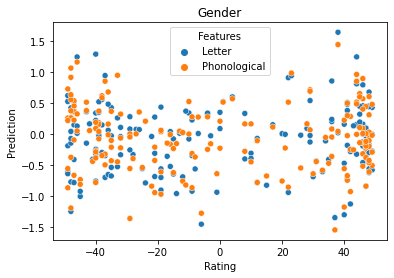

In [56]:
sns.scatterplot(x=NNGEN_pred["Rating"], y=NNGEN_pred["Prediction"], hue=NNGEN_pred["Features"]).set(title='Gender')

### Age

In [57]:
age_df = df.loc[df['age'].notnull(), ["name", "name_type", "age", "rating.mean_age", "letter_vec", "phonological_vec"]]
age_df.reset_index(drop=True, inplace=True)

### - - - -

In [58]:
NNLF_age = train_NN(age_df, "letter_vec", "rating.mean_age")

In [59]:
NNLFAGE_results = metrics_and_eval(NNLF_age)

In [60]:
print("Avg MAE: ", NNLFAGE_results[0], "Avg MAE per name type: ", NNLFAGE_results[1], "R2: ", NNLFAGE_results[2], 
      "Avg MSE: ", NNLFAGE_results[4], "Median AE: ", NNLFAGE_results[5], sep="\n")

Avg MAE: 
16.913140441517996
Avg MAE per name type: 
{'real': 18.321958989836276, 'talking': 16.815356642780145, 'madeup': 15.535677120873803}
R2: 
-0.013448534296355508
Avg MSE: 
401.48678659634396
Median AE: 
15.762773513793945


In [61]:
NNLFAGE_pred = pd.DataFrame(NNLF_age, columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
NNLFAGE_pred["Features"] = ["Letter" for i in range(len(NNLF_age))]

In [62]:
NNLFAGE_pred.to_csv("NNLFAGE_pred.csv")

In [63]:
NNPF_age = train_NN(age_df, "phonological_vec", "rating.mean_age")

In [64]:
NNPFAGE_results = metrics_and_eval(NNPF_age)

In [65]:
print("Avg MAE: ", NNPFAGE_results[0], "Avg MAE per name type: ", NNPFAGE_results[1], "R2: ", NNPFAGE_results[2], 
      "Avg MSE: ", NNPFAGE_results[4], "Median AE: ", NNPFAGE_results[5], sep="\n")

Avg MAE: 
16.7899209547694
Avg MAE per name type: 
{'real': 18.110366316325962, 'talking': 16.90259739374969, 'madeup': 15.278406521599544}
R2: 
0.0030455856210636068
Avg MSE: 
394.9524920769117
Median AE: 
15.916839227080345


In [66]:
NNPFAGE_pred = pd.DataFrame(NNPF_age, columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
NNPFAGE_pred["Features"] = ["Phonological" for i in range(len(NNPF_age))]

In [67]:
NNPFAGE_pred.to_csv("NNPFAGE_pred.csv")

In [68]:
NNAGE_pred = NNLFAGE_pred.append(NNPFAGE_pred)

In [69]:
NNAGE_pred.to_csv("NNAGE_pred.csv")

[Text(0.5, 1.0, 'Age')]

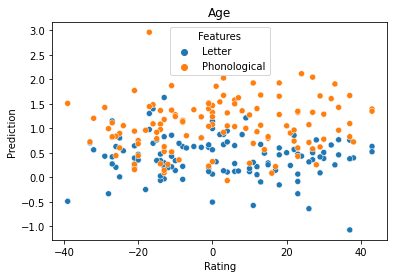

In [70]:
sns.scatterplot(x=NNAGE_pred["Rating"], y=NNAGE_pred["Prediction"], hue=NNAGE_pred["Features"]).set(title='Age')